# DL Assignment #1 | Problem Set #1 (Part -1) | Group 41 Submission:

### <u>Problem statement</u>: 
##### Question No.1. Vision Dataset:imagenette/160px-v2-Imagenette is a subset of 10 easily classified classes from the Imagenet dataset. Please find your dataset from the link -https://www.tensorflow.org/datasets/catalog/imagenette

### Group Members (in Alphabetical # order):
- 2019AD04031 - <b>Aditya Mehta</b>
- 2019AD04026 - <b>Ankit Gupta</b>
- 2019AD04027 - <b>Hitesh Gupta</b>

### **1. Import Libraries/ Dataset**

a. Import the required libraries and the dataset (use Google Drive if required).

b. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [50]:
import os
import tarfile

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from timeit import default_timer as timer

from sklearn.metrics import classification_report, confusion_matrix
import itertools

print(tf.__version__)

2.4.1


In [51]:
# copy dataset
!wget --no-check-certificate \
  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz \
  -O /tmp/imagenette2-160.tgz

--2021-05-23 13:51:37--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.111.166
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.111.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘/tmp/imagenette2-160.tgz’

/tmp/imagenette2-16 100%[===================>]  94.42M  98.3MB/s    in 1.0s    

2021-05-23 13:51:38 (98.3 MB/s) - ‘/tmp/imagenette2-160.tgz’ saved [99003388/99003388]



In [52]:
# open file
file = tarfile.open('/tmp/imagenette2-160.tgz')
  
# extract file
file.extractall('/tmp')

#close file
file.close()

In [53]:
# set directories
base_dir = '/tmp/imagenette2-160'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

### **2. Data Visualization and Augmentation**

a. Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).

b. Apply rotation and height shift augmentation (rotation_range, height_shift_range) to the dataset separately. Print the augmented image and the original image for each class and each augmentation.

c. Bring the train and test data in the required format.

d. Print the shapes of train and test data.



In [54]:
# set image and batch size
num_img_rows=75 # image height, actual=213
num_img_cols=75 # image width, actual=160
num_color_channels=3
num_batch_size=100

train_datagen = ImageDataGenerator(
                  rescale=1.0/255.0,
                  rotation_range=40,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                )

val_datagen = ImageDataGenerator(
                rescale=1.0/255.0
              )

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    batch_size=num_batch_size,
                    target_size=(num_img_rows, num_img_cols),
                    class_mode='categorical'
                  )

val_generator = val_datagen.flow_from_directory(
                  val_dir,
                  batch_size=num_batch_size,
                  target_size=(num_img_rows, num_img_cols),
                  class_mode='categorical'
                )

# print shape of training data after transformation
for train_image_batch, train_labels_batch in train_generator:
  print('Training image batch shape, after transformation:', train_image_batch.shape)
  print('Training label batch shape, after transformation:', train_labels_batch.shape)
  break

# print shape of test data after transformation
for val_image_batch, val_labels_batch in val_generator:
  print('Validation image batch shape, after transformation:', val_image_batch.shape)
  print('Validation label batch shape, after transformation:', val_labels_batch.shape)
  break

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Training image batch shape, after transformation: (100, 75, 75, 3)
Training label batch shape, after transformation: (100, 10)
Validation image batch shape, after transformation: (100, 75, 75, 3)
Validation label batch shape, after transformation: (100, 10)


In [55]:
# Preparing ImageDataGenerator for augmentation

train_datagen_rotate = ImageDataGenerator(rescale=1/255, rotation_range=30, fill_mode='nearest')
train_datagen_hshift = ImageDataGenerator(rescale=1/255, height_shift_range=0.3)

hshift_train_dir = '/tmp/imagenette2-160/train_hshift'
rotate_train_dir = '/tmp/imagenette2-160/train_rotate'

## Data Augumentation... 
def apply_augmentation(train_dir, tgt_dir, img_datagen):
  print ('\n', "Applying Augmentation to Target directory :", tgt_dir)
  for i, folder_name in enumerate(os.listdir(train_dir)):
    if (folder_name != '.DS_Store'):
      hshift_folder_name = '/tmp/imagenette2-160/' + tgt_dir +'/' + folder_name
      if (os.path.exists(hshift_folder_name) == False):
        os.makedirs(hshift_folder_name)

      img_placeholder = []
      folder_name = '/tmp/imagenette2-160/train/' + folder_name + '/'
      folder_images = os.listdir(folder_name)
      print ("Processing folder: ", folder_name)

      for j, img_name in enumerate(folder_images):
        tmp_image = image.load_img(folder_name + img_name)
        x = image.img_to_array(tmp_image)  # this is a Numpy array with shape (160, 160, 3)    
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 160, 160, 3)
        # train_datagen_hflip.flow(x, batch_size=512,save_to_dir= hshift_folder_name, save_prefix=img_name,save_format="jpeg")
        k = 0
        for batch in img_datagen.flow(x, batch_size=512,save_to_dir= hshift_folder_name, save_prefix=img_name,save_format="jpeg"):
          k += 1
          # print ("in flow func | folder_name", img_name, folder_name)
          if k > 0:
            break  # otherwise the generator would loop indefinitely
      
      aug_folder_images = os.listdir(hshift_folder_name + '/')
      for k, aug_img_name in enumerate(aug_folder_images):
          new_img_name = aug_img_name.split('.')[0]
          new_img_name = new_img_name + '.jpeg'
          src = hshift_folder_name + '/' + aug_img_name
          dst = hshift_folder_name + '/' + new_img_name
          os.rename(src,dst)

def get_pics_list(train_dir, num_imgs):
  print ("Getting pictures list...")
  pic = {}
  pic_names_list = {}
  for dir in os.listdir(train_dir):
    if (dir != ".DS_Store"):
      print("processing dir :", dir)
      i = 0
      for fname in os.listdir(os.path.join(train_dir,dir)): 
        if (i < num_imgs):
          # print("processing file :", i, ":", fname)
          # pic.append(os.path.join(train_dir,dir,fname))
          pic[dir + '_'+str(i)] = os.path.join(train_dir,dir,fname)
          pic_names_list[dir + '_'+str(i)] = fname
        i += 1
  return pic_names_list 
def print_sample_imgs(pic):
  nrows = 20
  ncols = 3

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("======================================================")
  print("Printing Sample image with Height shift and Rotation :")
  print("======================================================")
  j = 0
  for i, img_nm in enumerate(pic.keys()):
    just_img_nm = img_nm.split(sep='_')[0]
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, j + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    sp.set_title(just_img_nm)
    # printing main img
    raw_img_nm = train_dir + '/' + just_img_nm + '/' + pic[img_nm]
    img = mpimg.imread(raw_img_nm)
    # print (raw_img_nm)
    plt.imshow(img)

    sp = plt.subplot(nrows, ncols, j + 2)
    sp.axis('Off') # Don't show axes (or gridlines)
    sp.set_title(just_img_nm + '(Height_Shift)')
    hshift_img_nm = hshift_train_dir + '/' + just_img_nm + '/' + pic[img_nm].split(sep='.')[0] + '.jpeg'
    aug_img = mpimg.imread(hshift_img_nm)
    # print (hshift_img_nm)
    plt.imshow(aug_img)
    
    sp = plt.subplot(nrows, ncols, j + 3)
    sp.axis('Off') # Don't show axes (or gridlines)
    sp.set_title(just_img_nm + '(Rotation)')
    rot_img_nm = rotate_train_dir + '/' + just_img_nm + '/' + pic[img_nm].split(sep='.')[0] + '.jpeg'
    rot_img = mpimg.imread(rot_img_nm)
    # print (rot_img_nm)
    plt.imshow(rot_img)
    
    
    j = j + 3
  plt.show()
  # plt.show()

In [36]:
pics_list = get_pics_list('/tmp/imagenette2-160/train/', 2)

Getting pictures list...
processing dir : n03028079
processing dir : n01440764
processing dir : n03445777
processing dir : n03888257
processing dir : n03417042
processing dir : n03425413
processing dir : n02102040
processing dir : n03000684
processing dir : n03394916
processing dir : n02979186


Printing Sample (2) images from each Label :


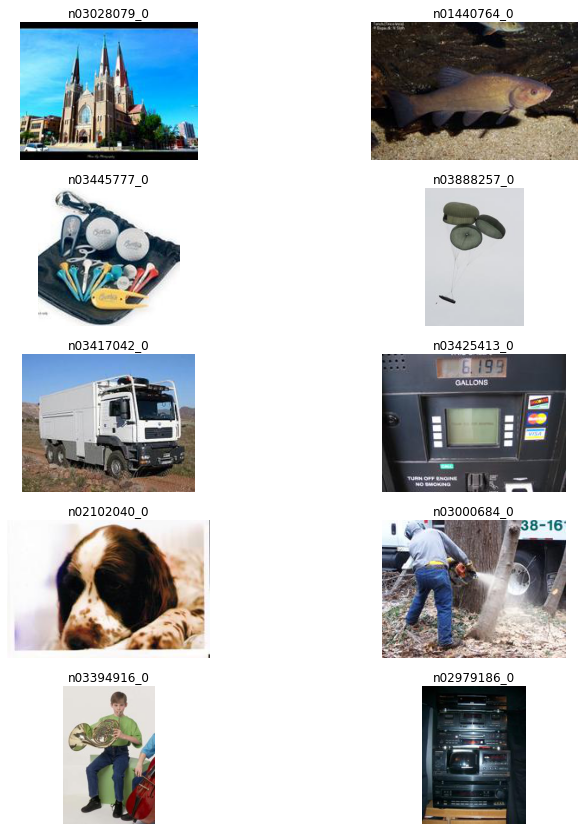

In [57]:
# Printing sample images from each target class

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 10
ncols = 2
  # Index for iterating over images
pic_index = 0 
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 6, nrows * 3)

print("============================================")
print("Printing Sample (2) images from each Label :")
print("============================================")
for i, img_path in enumerate(pics_list.keys()):
  just_img_nm = img_path.split(sep='_')[0]
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  sp.set_title(img_path)
  raw_img_nm = train_dir + '/' + just_img_nm + '/' + pics_list[img_path]
  img = mpimg.imread(raw_img_nm)
  plt.imshow(img)

plt.show()

Getting pictures list...
processing dir : n03028079
processing dir : n01440764
processing dir : n03445777
processing dir : n03888257
processing dir : n03417042
processing dir : n03425413
processing dir : n02102040
processing dir : n03000684
processing dir : n03394916
processing dir : n02979186

 Applying Augmentation to Target directory : train_hshift
Processing folder:  /tmp/imagenette2-160/train/n03028079/
Processing folder:  /tmp/imagenette2-160/train/n01440764/
Processing folder:  /tmp/imagenette2-160/train/n03445777/
Processing folder:  /tmp/imagenette2-160/train/n03888257/
Processing folder:  /tmp/imagenette2-160/train/n03417042/
Processing folder:  /tmp/imagenette2-160/train/n03425413/
Processing folder:  /tmp/imagenette2-160/train/n02102040/
Processing folder:  /tmp/imagenette2-160/train/n03000684/
Processing folder:  /tmp/imagenette2-160/train/n03394916/
Processing folder:  /tmp/imagenette2-160/train/n02979186/

 Applying Augmentation to Target directory : train_rotate
Process

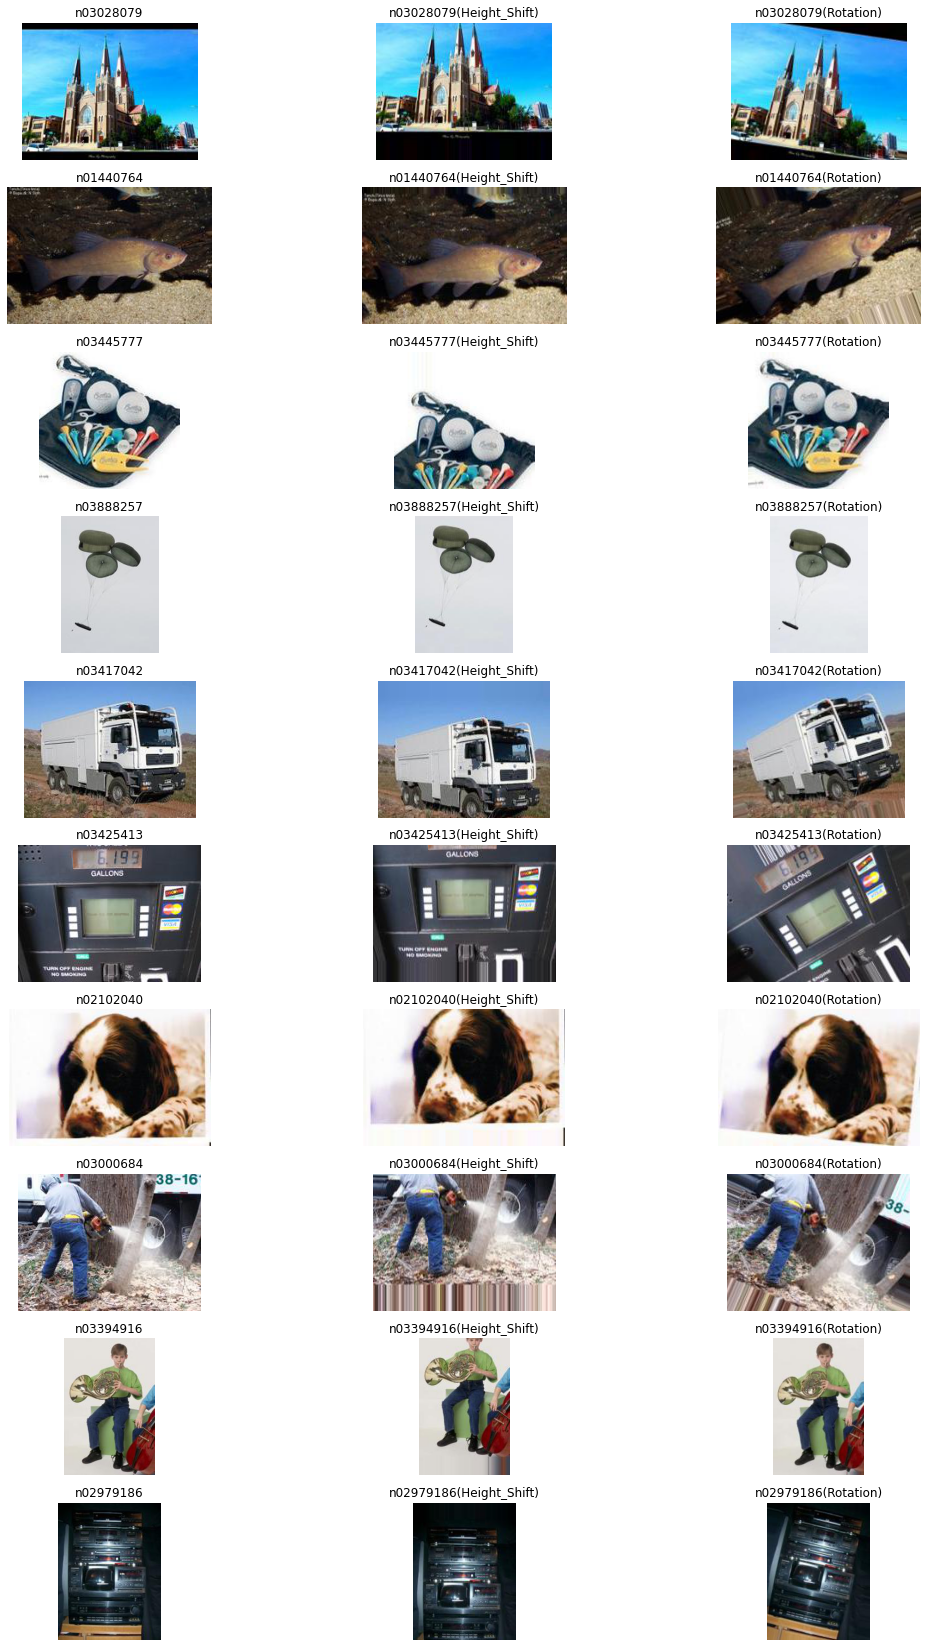

In [58]:
# Printing Augmented images

pics_list = get_pics_list('/tmp/imagenette2-160/train/', 1)

#Applying Augmentation
apply_augmentation(train_dir, "train_hshift", train_datagen_hshift)
apply_augmentation(train_dir, "train_rotate", train_datagen_rotate)

#printing Augmented images
print_sample_imgs(pics_list)

### **3. Model Building**

a. Sequential Model layers- Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.

d. Choose the appropriate activation function for all the layers.

e. Print the model summary.

In [59]:
# set model parameters
num_epochs=50
num_steps_per_epoch=95 # total training images/ batch size = 9465/100
num_val_steps=40 # total validation images/ batch size = 3925/100
num_dropout=0.2
num_l2_reg_penalty=0.0001
num_lr=1e-4
opt = RMSprop(lr=num_lr)
str_loss = 'categorical_crossentropy'

# build model
model = tf.keras.models.Sequential([
          # Flatten input
          tf.keras.layers.Flatten(input_shape=(num_img_rows,num_img_cols, num_color_channels)),
          # Layer 1 = input layer with regularization
          tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Add dropout
          tf.keras.layers.Dropout(num_dropout),
          # Layer 2 = hidden layer with regularization
          tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 3 = hidden layer with regularization
          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 4 = hidden layer with regularization
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 5 = output layer with regularization
          tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
        ])

### **4. Model Compilation**

a. Compile the model with the appropriate loss function.

b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

c. Use accuracy as a metric.

Give reasons for the choice of learning rate and its value. 
>- **Learning Rate** choosen in RMSProp is 0.0001. 
>- **Reason**: We have trained model with multiple learning rates and found that too low a learning rate never progresses, and too high a learning rate causes instability and never converges. And, we saw that 0.0001 is looking good. That's how we finalized it. 


In [60]:
# compile model
model.compile(loss=str_loss,
              optimizer=opt,
              metrics=['accuracy']
             )

**5. Model Training**

a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [61]:
# timing callback class
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# timing callback
timing = TimingCallback()

# train model
history = model.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=num_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=num_val_steps,
            verbose=1,
            callbacks=[timing]
          )

# show model summary
model.summary()

# total training time
print('\n', 'Total time taken for training: {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

# save model
#model.save("vision.h5")

Epoch 1/50
95/95 [==============================] - 22s 219ms/step - loss: 2.6991 - accuracy: 0.1427 - val_loss: 2.4211 - val_accuracy: 0.2224
Epoch 2/50
95/95 [==============================] - 20s 215ms/step - loss: 2.4208 - accuracy: 0.2165 - val_loss: 2.2502 - val_accuracy: 0.2739
Epoch 3/50
95/95 [==============================] - 21s 216ms/step - loss: 2.2757 - accuracy: 0.2517 - val_loss: 2.1387 - val_accuracy: 0.2932
Epoch 4/50
95/95 [==============================] - 20s 216ms/step - loss: 2.1905 - accuracy: 0.2766 - val_loss: 2.0956 - val_accuracy: 0.3047
Epoch 5/50
95/95 [==============================] - 21s 216ms/step - loss: 2.1569 - accuracy: 0.2849 - val_loss: 2.0387 - val_accuracy: 0.3330
Epoch 6/50
95/95 [==============================] - 21s 218ms/step - loss: 2.1157 - accuracy: 0.2948 - val_loss: 2.0082 - val_accuracy: 0.3460
Epoch 7/50
95/95 [==============================] - 20s 216ms/step - loss: 2.0584 - accuracy: 0.3154 - val_loss: 1.9869 - val_accuracy: 0.3529

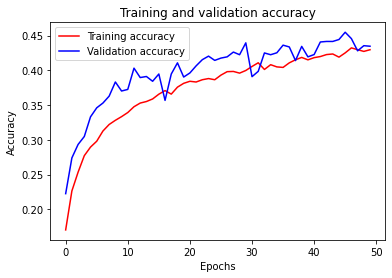

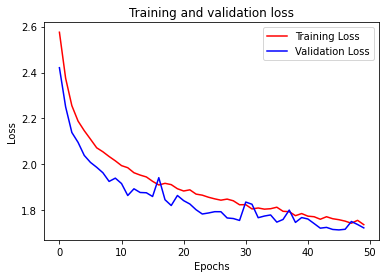

<Figure size 432x288 with 0 Axes>

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

**6. Model Evaluation**

a. Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b. Print the two most incorrectly classified images for each class in the test dataset.


In [63]:
# final training accuracy and loss
print('\n')
train_score = model.evaluate(train_generator)

print("Training accuracy: {:.2f}%".format(train_score[1] * 100)) 
print("Training Loss: ",train_score[0])

# final validation accuracy and loss
print('\n')
val_score = model.evaluate(val_generator)

print("Validation accuracy: {:.2f}%".format(val_score[1] * 100)) 
print("Validation Loss: ",val_score[0])



95/95 [==============================] - 17s 184ms/step - loss: 1.6884 - accuracy: 0.4480
Training accuracy: 44.80%
Training Loss:  1.688444972038269


40/40 [==============================] - 3s 78ms/step - loss: 1.7227 - accuracy: 0.4346
Validation accuracy: 43.46%
Validation Loss:  1.7227396965026855


In [64]:
# get target names
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print target_names
print('Target names:', target_names, '\n')

# Print Confusion Matrix for validation dataset
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_generator.classes, y_pred)
print('Confusion Matrix for validation dataset', '\n', cm, '\n')

# Print Classification Report for validation dataset
print('Classification Report for validation dataset')
print(classification_report(val_generator.classes, y_pred, target_names=target_names))

Target names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257'] 

Confusion Matrix for validation dataset 
 [[52 36 37 19 51 49 29 28 28 58]
 [59 38 34 18 48 44 37 24 23 70]
 [66 28 28 21 42 39 33 18 30 52]
 [60 47 32 22 45 40 42 20 28 50]
 [67 45 45 11 39 58 32 20 28 64]
 [49 52 38 19 45 33 40 25 34 59]
 [47 39 39 22 39 47 22 29 35 70]
 [54 46 49 21 36 51 36 26 37 63]
 [64 48 37 19 44 43 24 26 24 70]
 [68 35 39 13 47 45 30 26 25 62]] 

Classification Report for validation dataset
              precision    recall  f1-score   support

   n01440764       0.09      0.13      0.11       387
   n02102040       0.09      0.10      0.09       395
   n02979186       0.07      0.08      0.08       357
   n03000684       0.12      0.06      0.08       386
   n03028079       0.09      0.10      0.09       409
   n03394916       0.07      0.08      0.08       394
   n03417042       0.07      0.06      0.06       389


In [2]:
# Y_pred_proba = model.predict(val_generator)
def get_worst_predicted_images():
    predict_proba_list = []
    # ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

    for i in range(0,len(val_generator.labels)):
      if (val_generator.labels[i] == 0):
        predict_proba_list.append([i, 'n01440764', Y_pred_proba[i][0]])
      elif (val_generator.labels[i] == 1):
        predict_proba_list.append([i, 'n02102040', Y_pred_proba[i][1]])
      elif (val_generator.labels[i] == 2):
        predict_proba_list.append([i, 'n02979186', Y_pred_proba[i][2]])
      elif (val_generator.labels[i] == 3):
        predict_proba_list.append([i, 'n03000684', Y_pred_proba[i][3]])
      elif (val_generator.labels[i] == 4):
        predict_proba_list.append([i, 'n03028079', Y_pred_proba[i][4]])
      elif (val_generator.labels[i] == 5):
        predict_proba_list.append([i, 'n03394916', Y_pred_proba[i][5]])
      elif (val_generator.labels[i] == 6):
        predict_proba_list.append([i, 'n03417042', Y_pred_proba[i][6]])
      elif (val_generator.labels[i] == 7):
        predict_proba_list.append([i, 'n03425413', Y_pred_proba[i][7]])
      elif (val_generator.labels[i] == 8):
        predict_proba_list.append([i, 'n03445777', Y_pred_proba[i][8]])
      elif (val_generator.labels[i] == 9):
        predict_proba_list.append([i, 'n03888257', Y_pred_proba[i][9]])

    df = pd.DataFrame(predict_proba_list, columns=['img_index','label','proba'])
    df1 = df.groupby(['label']).agg({'proba':'min'}).reset_index()
    min_proba_list = df1['proba'].to_list()
    # create df of min proba images
    df1 = df[df['proba'].isin(min_proba_list)].copy()

In [3]:
# Below is the output by running above function which tells the Indexes of images of each class which performed worst.

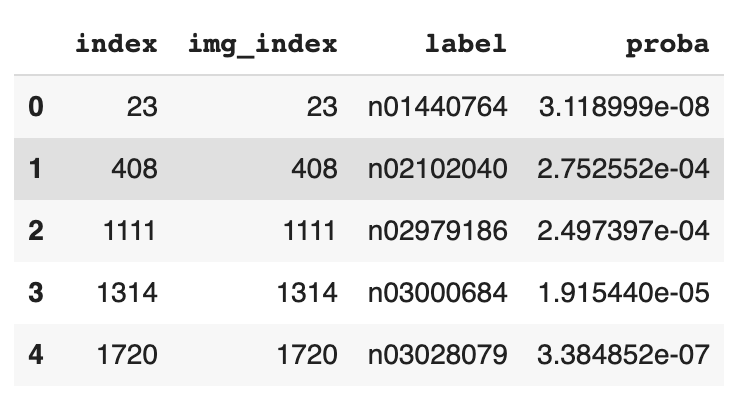

**Hyperparameter Tuning**

Build two more additional models by changing the following hyperparameters ONE at a time. Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model.

1. Network Depth: Change the number of hidden layers and hidden units for each layer

2. Regularization: Train a model without regularization

Write a comparison between each model and give reasons for the difference in results.

Epoch 1/50
95/95 [==============================] - 22s 221ms/step - loss: 2.5453 - accuracy: 0.1445 - val_loss: 2.2787 - val_accuracy: 0.2655
Epoch 2/50
95/95 [==============================] - 21s 218ms/step - loss: 2.3299 - accuracy: 0.2332 - val_loss: 2.2149 - val_accuracy: 0.2525
Epoch 3/50
95/95 [==============================] - 21s 219ms/step - loss: 2.2350 - accuracy: 0.2593 - val_loss: 2.0932 - val_accuracy: 0.3233
Epoch 4/50
95/95 [==============================] - 21s 220ms/step - loss: 2.1723 - accuracy: 0.2830 - val_loss: 2.0979 - val_accuracy: 0.3121
Epoch 5/50
95/95 [==============================] - 21s 219ms/step - loss: 2.1262 - accuracy: 0.3049 - val_loss: 2.0494 - val_accuracy: 0.3338
Epoch 6/50
95/95 [==============================] - 21s 221ms/step - loss: 2.0972 - accuracy: 0.3013 - val_loss: 2.1172 - val_accuracy: 0.2904
Epoch 7/50
95/95 [==============================] - 21s 218ms/step - loss: 2.0739 - accuracy: 0.3172 - val_loss: 1.9664 - val_accuracy: 0.3587

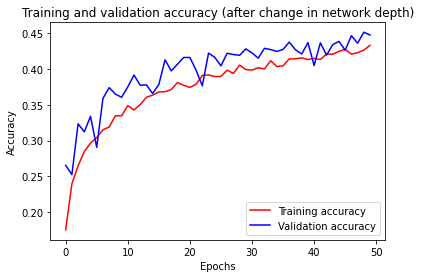

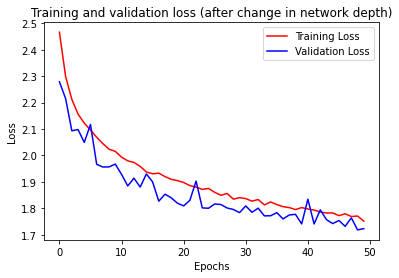

<Figure size 432x288 with 0 Axes>



95/95 [==============================] - 18s 188ms/step - loss: 1.6770 - accuracy: 0.4504
Training accuracy (after change in network depth): 45.04%
Training Loss (after change in network depth):  1.676950454711914


40/40 [==============================] - 3s 79ms/step - loss: 1.7231 - accuracy: 0.4471
Validation accuracy (after change in network depth): 44.71%
Validation Loss (after change in network depth):  1.7231096029281616


In [65]:
# change number of hidden layers and hidden units for each layer

# build model1 - added one hidden layer and changed hidden units for each layer
model1 = tf.keras.models.Sequential([
          # Flatten input
          tf.keras.layers.Flatten(input_shape=(num_img_rows,num_img_cols, num_color_channels)),
          # Layer 1 = input layer with regularization
          tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Add dropout
          tf.keras.layers.Dropout(num_dropout),
          # Layer 2 = input layer with regularization
          tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 3 = hidden layer with regularization
          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 4 = hidden layer with regularization
          tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 5 = hidden layer with regularization
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
          # Layer 6 = output layer with regularization
          tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)),
        ])

# compile model1
model1.compile(loss=str_loss,
              optimizer=opt,
              metrics=['accuracy']
             )

# train model1
history1 = model1.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=num_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=num_val_steps,
            verbose=1,
            callbacks=[timing]
          )

# show model1 summary
model1.summary()

# total training time for model 1
print('\n', 'Total time taken for training (after change in network depth): {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (after change in network depth)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss (after change in network depth)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

# evaluate on train dataset
print('\n')
train1_score = model1.evaluate(train_generator)

# final training accuracy and loss
print("Training accuracy (after change in network depth): {:.2f}%".format(train1_score[1] * 100)) 
print("Training Loss (after change in network depth): ",train1_score[0])

# evaluate on validation dataset
print('\n')
val1_score = model1.evaluate(val_generator)

# final validation accuracy and loss
print("Validation accuracy (after change in network depth): {:.2f}%".format(val1_score[1] * 100)) 
print("Validation Loss (after change in network depth): ",val1_score[0])

Epoch 1/50
95/95 [==============================] - 22s 223ms/step - loss: 2.4321 - accuracy: 0.1457 - val_loss: 2.0860 - val_accuracy: 0.2313
Epoch 2/50
95/95 [==============================] - 21s 221ms/step - loss: 2.1439 - accuracy: 0.2214 - val_loss: 2.1024 - val_accuracy: 0.2499
Epoch 3/50
95/95 [==============================] - 21s 221ms/step - loss: 2.0963 - accuracy: 0.2482 - val_loss: 1.9656 - val_accuracy: 0.3187
Epoch 4/50
95/95 [==============================] - 21s 221ms/step - loss: 2.0470 - accuracy: 0.2681 - val_loss: 1.9750 - val_accuracy: 0.3019
Epoch 5/50
95/95 [==============================] - 21s 222ms/step - loss: 2.0208 - accuracy: 0.2776 - val_loss: 1.9788 - val_accuracy: 0.3045
Epoch 6/50
95/95 [==============================] - 21s 220ms/step - loss: 1.9960 - accuracy: 0.2926 - val_loss: 1.9540 - val_accuracy: 0.3118
Epoch 7/50
95/95 [==============================] - 21s 221ms/step - loss: 1.9748 - accuracy: 0.3041 - val_loss: 1.8699 - val_accuracy: 0.3552

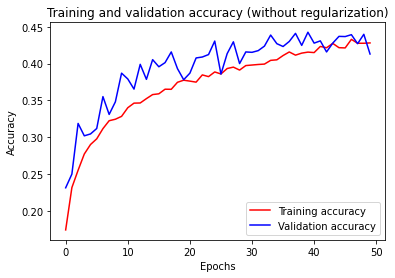

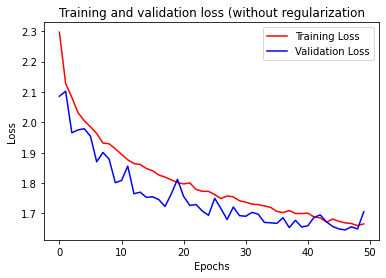

<Figure size 432x288 with 0 Axes>



95/95 [==============================] - 18s 187ms/step - loss: 1.6490 - accuracy: 0.4289
Training accuracy (without regularization): 42.89%
Training Loss (without regularization):  1.6490235328674316


40/40 [==============================] - 3s 79ms/step - loss: 1.7054 - accuracy: 0.4130
Validation accuracy (without regularization): 41.30%
Validation Loss (without regularization):  1.7053899765014648


In [66]:
# train a model without regularization - removing kernel regularization

# build model2
model2 = tf.keras.models.Sequential([
          # Flatten input
          tf.keras.layers.Flatten(input_shape=(num_img_rows,num_img_cols, num_color_channels)),
          # Layer 1 = input layer without regularization
          tf.keras.layers.Dense(1024, activation='relu'),
          # Add dropout
          tf.keras.layers.Dropout(num_dropout),
          # Layer 2 = hidden layer without regularization
          tf.keras.layers.Dense(512, activation='relu'),
          # Layer 3 = hidden layer without regularization
          tf.keras.layers.Dense(256, activation='relu'),
          # Layer 4 = hidden layer without regularization
          tf.keras.layers.Dense(128, activation='relu'),
          # Layer 5 = output layer without regularization
          tf.keras.layers.Dense(10, activation='softmax'),
        ])

# compile model2
model2.compile(loss=str_loss,
              optimizer=opt,
              metrics=['accuracy']
             )

# train model2
history2 = model2.fit(
            train_generator,
            epochs=num_epochs,
            steps_per_epoch=num_steps_per_epoch,
            validation_data=val_generator,
            validation_steps=num_val_steps,
            verbose=1,
            callbacks=[timing]
          )

# show model2 summary
model2.summary()

# total training time for model 2
print('\n', 'Total time taken for training (without regularization): {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy (without regularization)')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss (without regularization)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

# evaluate on train dataset
print('\n')
train2_score = model2.evaluate(train_generator)

# final training accuracy and loss
print("Training accuracy (without regularization): {:.2f}%".format(train2_score[1] * 100)) 
print("Training Loss (without regularization): ",train2_score[0])

# evaluate on validation dataset
print('\n')
val2_score = model2.evaluate(val_generator)

# final validation accuracy and loss
print("Validation accuracy (without regularization): {:.2f}%".format(val2_score[1] * 100)) 
print("Validation Loss (without regularization): ",val2_score[0])

### Write a comparison between each model and give reasons for the difference in results.

                      Model0        Model1         Model2
                      (original)    (net depth)    (without reg)
Train Accuracy (%) =          44.80         45.04          42.89
Val Accuracy   (%) =          43.46         44.71          41.30
Training Time (s)  =        1025.22       2073.46        3125.67
Total Params       =  17,971,338     9,134,474      17,971,338

The training and validation accuracy of all three models is similar for 50 epochs.

Model1 (change in network depth) takes 2 times more training time than Model0, as it has 1 layer more.

Model2 (without regularization) takes 3 times more training time than Model0, as convergence without regularization takes more time.